In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# location_path = "/content/drive/MyDrive/programming/_00_gibbs_phenomenon_studying/examples/"
# os.chdir(location_path)
# os.getcwd()

In [11]:
import os

import numpy as np
from numpy import roll

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

# next point np.roll(u, -1)
# previous point np.roll(u, 1)

### parameters ###
L, T = 1, 0.5
dx = 0.01
c, CFL = 1, 0.2 # as shift must be at least 1 for the exact solution to be correct, so c must be 1/CFL

N_x = int(L/dx)
x = np.linspace(-L/2, L/2, N_x)

dt = CFL * dx
N_t = int(T/dt)

width, height, center = 0.5, 1, 0.0

### initial and periodic boundary condition ###
def u_square_wave(x,width,height,center):
    return np.where(np.abs(x-center) <= width/2, height, 0)

def initial_condition(x, width, height, center):
    u_initial = u_square_wave(x,width,height,center)
    return u_initial

### The discretized flux ###
def F(u):
    up1, um1 = roll(u, -1), roll(u, 1)
    du_dx = (up1 - um1) / (2 * dx)
    return -c * du_dx

### The exact solution of the Burgers equation ###
def d_alembert_solution(x,t, width, height, center): # linear_advection_step_periodic
    x_shift = x - c*t
    x_shift = (x_shift + L / 2) % L - L / 2
    u = initial_condition(x_shift, width, height, center)
    return u

### RK4 ###
def RK4(u):
    k1 = F(u)
    k2 = F(u + 0.5 * dt * k1)
    k3 = F(u + 0.5 * dt * k2)
    k4 = F(u + dt * k3)
    return u + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

### TVD RK3 ###
def du_dx_h4(u):
    # up2, up1, um2, um1 = roll(u, -2), roll(u, -1), roll(u, 2), roll(u, 1)
    # return (-(up2 - um2)+8*(up1-um1)) / (12 * dx)
    return compute_ux(u,dx)

def TVD_RK3(u):
    du_dx = du_dx_h4(u)
    u1 = u - dt*du_dx

    du1_dx = du_dx_h4(u1)
    u2 = (3/4)*u + (1/4)*u1 - (1/4)*dt*du1_dx

    du2_dx = du_dx_h4(u2)
    u_tvd_rk3 = (1/3)*u + (2/3)*u2 - (2/3)*dt*du2_dx

    return u_tvd_rk3

### Filtering flux ###
def filter_flux(u):
    up1, up2, up3, up4 = roll(u, -1), roll(u, -2), roll(u, -3), roll(u, -4)
    um1, um2, um3, um4 = roll(u, 1), roll(u, 2), roll(u, 3), roll(u, 4)

    max_g, min_g = max(u), min(u)
    max_l = np.max([up2,up1,u,um1,um2],axis=0)
    min_l = np.min([up2,up1,u,um1,um2],axis=0)

    Ru = ( 4*(up1+um1) - (up2+um2) )/6.0

    ce,cs = 2000,0.1
    D = cs*(max_g-min_g) + (1-cs)*(max_l-min_l)+1e-6
    e = abs(Ru - u)/D
    ep1 = roll(e,-1)
    e = np.max([e,ep1],axis=0)
    w = 1-np.exp(-ce*e**2)

    f8 = (35*(up1-u)-21*(up2-um1)+7*(up3-um2)-(up4-um3))/(4**4) # eq. 2
    f2 = (up1-u)/4
    f = w*f2 + (1-w)*f8
    fm1 = roll(f,+1)
    Fu = u + dt/dx*(f - fm1) # eq. 1
    return Fu

### Darian's Derivative ###
def thomas(a_sub, b_diag, c_super, d):
    n = len(b_diag)
    if len(a_sub) != n-1 or len(c_super) != n-1 or len(d) != n:
        raise ValueError("Invalid input sizes in Thomas algorithm")
    cp = np.zeros(n-1)
    dp = np.zeros(n)
    # Forward sweep
    cp[0] = c_super[0] / b_diag[0]
    dp[0] = d[0] / b_diag[0]
    for i in range(1, n):
        denom = b_diag[i] - a_sub[i-1] * cp[i-1]
        if i < n-1:
            cp[i] = c_super[i] / denom
        dp[i] = (d[i] - a_sub[i-1] * dp[i-1]) / denom
    # Backward substitution
    x = np.zeros(n)
    x[-1] = dp[-1]
    for i in range(n-2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i+1]
    return x

def solve_cyclic_tridiagonal(n, a_sub_val, b_diag_val, c_super_val, d):
    # Construct non-cyclic tridiagonal matrix T
    a_sub = np.full(n-1, a_sub_val)
    a_sub[0] = 0.0
    b_diag = np.full(n, b_diag_val)
    c_super = np.full(n-1, c_super_val)
    c_super[-1] = 0.0

    # Solve T x1 = d
    x1 = thomas(a_sub, b_diag, c_super, d)

    # Prepare correction vectors
    u1 = np.zeros(n)
    u1[0] = a_sub_val
    u2 = np.zeros(n)
    u2[-1] = c_super_val

    # Solve for z1 and z2
    z1 = thomas(a_sub, b_diag, c_super, u1)
    z2 = thomas(a_sub, b_diag, c_super, u2)

    # Form and solve matrix C
    v1_z1 = z1[-1]
    v1_z2 = z2[-1]
    v2_z1 = z1[0]
    v2_z2 = z2[0]

    C = np.array([[1 + v1_z1, v1_z2],[v2_z1, 1 + v2_z2]])
    rhs = np.array([x1[-1], x1[0]])

    try:
        y = np.linalg.solve(C, rhs)
    except np.linalg.LinAlgError:
        raise ValueError("Matrix C is singular")

    # Compute corrected solution
    x = x1 - y[0] * z1 - y[1] * z2
    return x

def compute_ux(u, dx):
    n = u.size
    ux = u.copy()
    rhs = np.zeros(n)
    for i in range(n):
        ip = (i + 1) % n
        im = (i - 1) % n
        rhs[i] = (u[ip] - u[im]) / (2*dx)
        # ux[i] = (u[i] - u[im]) / (dx)
    alpha, beta, gamma = 1.0/6, 4.0/6, 1.0/6
    ux = solve_cyclic_tridiagonal(n, alpha, beta, gamma, rhs)
    return ux

### Create the animation and plot ###
def plot(u_list, title, save_anim=False, filename="numerical_solution", params=""):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(x, u_list[0])

    line, = ax.plot(x, u_list[0])
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.set_title(title)
    ax.set_ylim(-0.5, 1.5)  # Set y-axis limits based on expected solution range

    def update(frame):
        line.set_ydata(u_list[frame])
        ax.set_title(f"{title} (t = {frame * dt:.4f})\n{params}")
        return line,

    anim = animation.FuncAnimation(fig, update, frames=len(u_list), interval=100, blit=True)

    # Save the animation (optional)
    if save_anim:
        anim.save(f'{filename}.gif', writer='pillow')

    ax.plot(x, u_list[-1])
    plt.show()

### Plot training loss ###
def plot_training_loss(loss_list):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(loss_list)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.set_title('Training Loss')
    plt.show()

########################################################
### Advection equation: du/dt = -c * du/dx = F(u,x,t) ###
#########################################################
def solve_Advection_Equation(u_initial, solver, filter = None):
    u_exact_list = [u_initial.copy()]
    u_list = [u_initial.copy()]
    for ti in range(N_t):
        u_exact = d_alembert_solution(x,ti*dt, width, height, center)
        u_exact_list.append(u_exact.copy())
        u = u_list[-1]
        u = solver(u)
        if filter is not None:
            u = filter(u)
        u_list.append(u.copy())
    return np.array(u_exact_list), np.array(u_list)

#########################################################
### main ###
#########################################################

# params = f"$T$: {T}, $dt$: {dt}, $N_t$: {N_t}, $dx$: {dx}, $N_x$: {N_x}, $CFL$: {CFL}, $c$: {c}"
u_initial = initial_condition(x, width, height, center)

# # u_exact_list, u_list = solve_Advection_Equation(u_initial, step_rk3)
# u_exact_list, u_list = solve_Advection_Equation(u_initial, TVD_RK3, filter_flux)
# plot(u_exact_list, "Advection Equation Solution (Exact)")
# plot(u_list, "Advection Equation Solution")


Using device: cuda
Model loaded from gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch:  50 loss: 0.68029
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch: 100 loss: 0.77534
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth


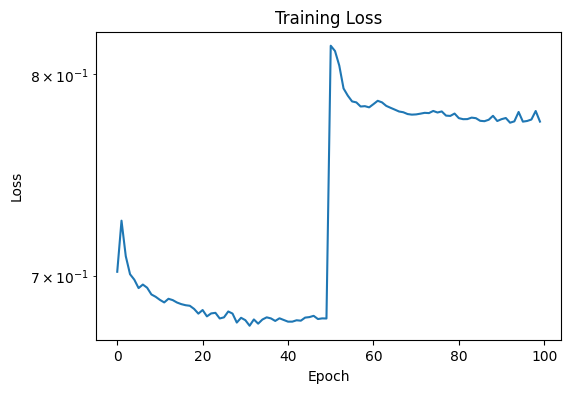

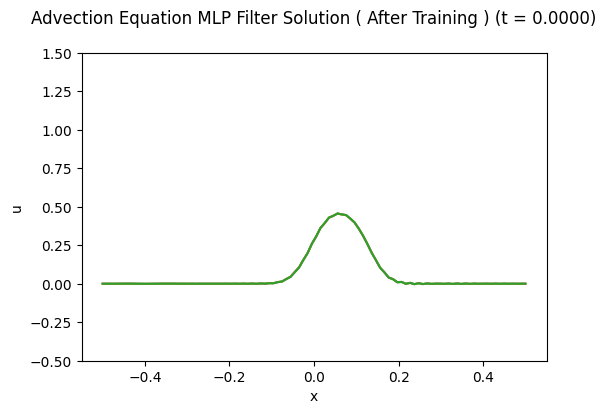

Model loaded from gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch:  50 loss: 1.36439
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch: 100 loss: 0.37537
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth


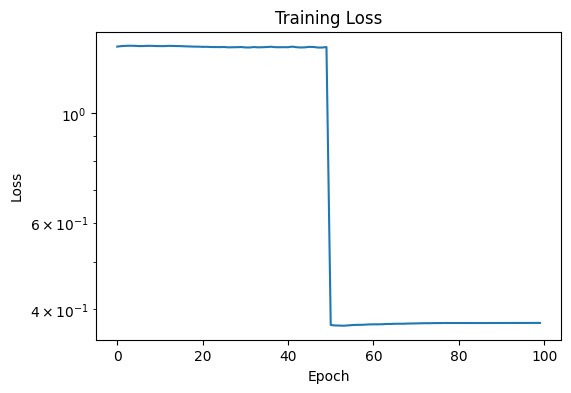

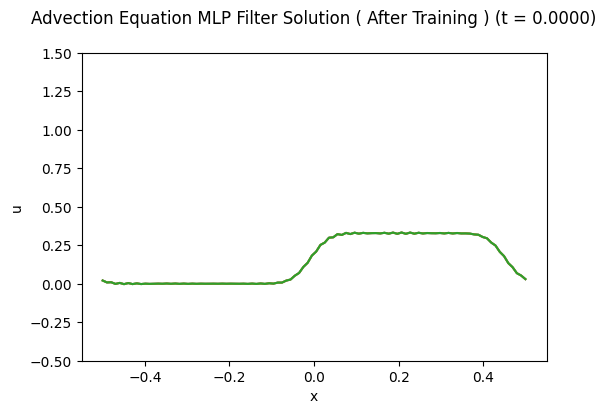

Model loaded from gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch:  50 loss: 0.47359
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch: 100 loss: 0.46763
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth


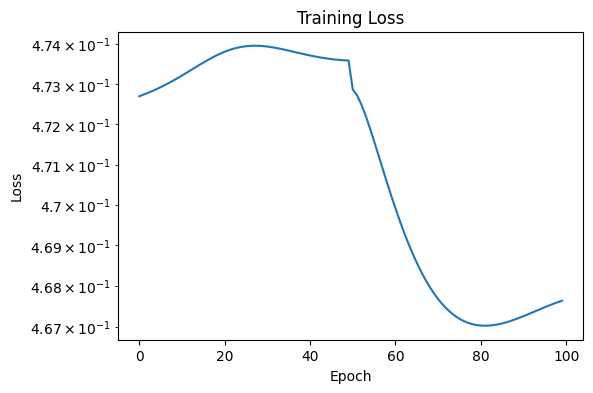

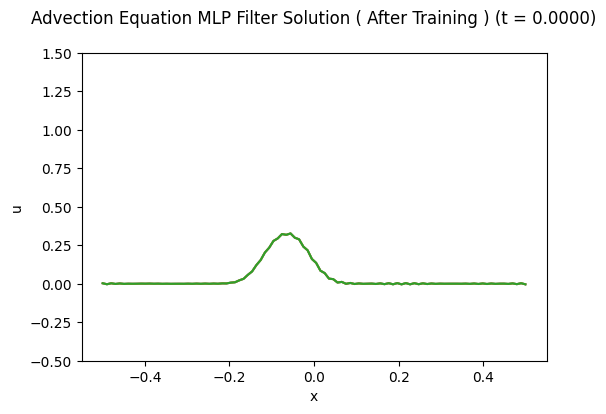

Model loaded from gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch:  50 loss: 1.87672
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch: 100 loss: 0.08943
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth


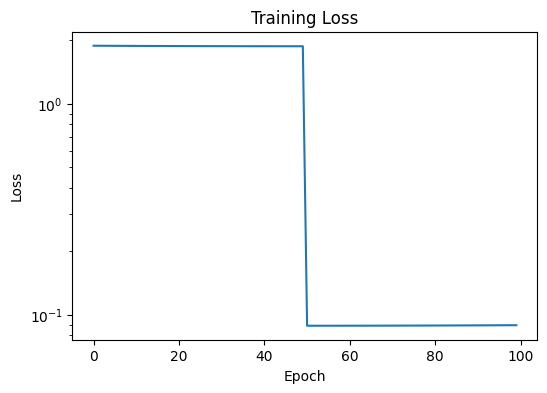

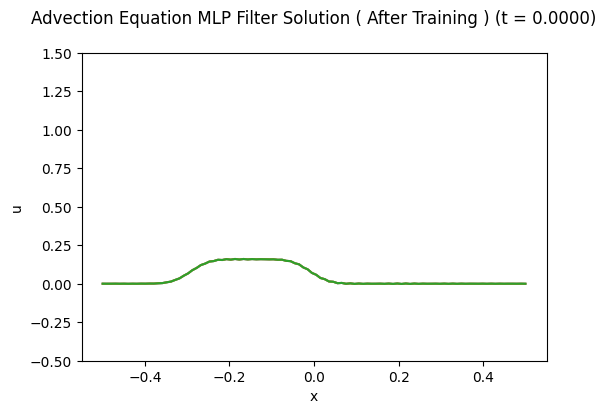

Model loaded from gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch:  50 loss: 1.75185
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch: 100 loss: 1.65895
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth


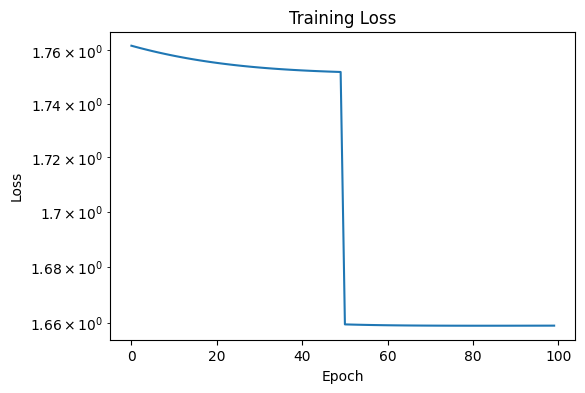

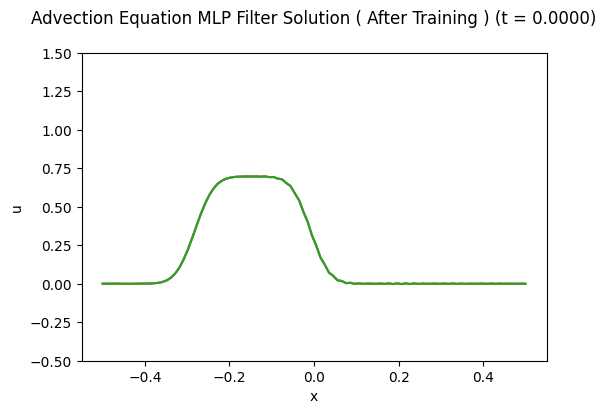

Model loaded from gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch:  50 loss: 3.21769
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch: 100 loss: 0.50240
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth


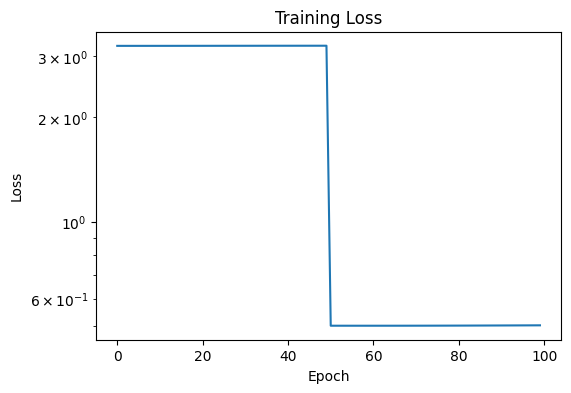

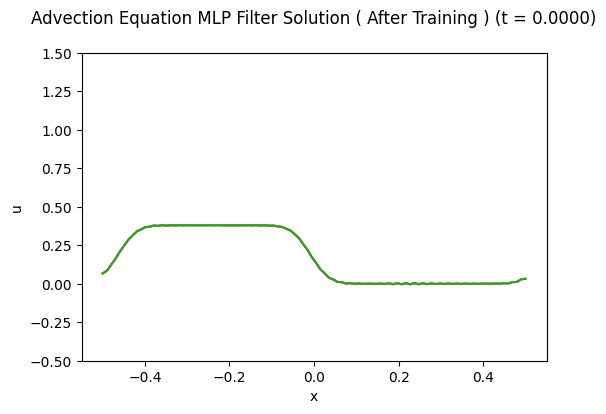

Model loaded from gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch:  50 loss: 0.42697
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch: 100 loss: 0.20914
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth


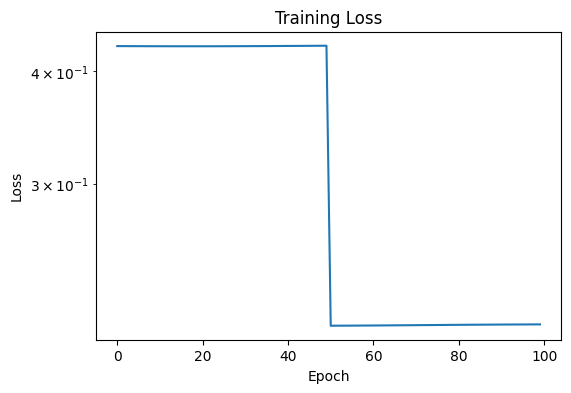

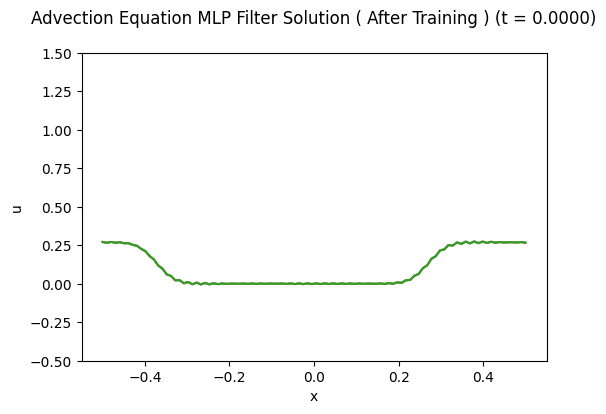

Model loaded from gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch:  50 loss: 2.22730
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch: 100 loss: 1.00284
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth


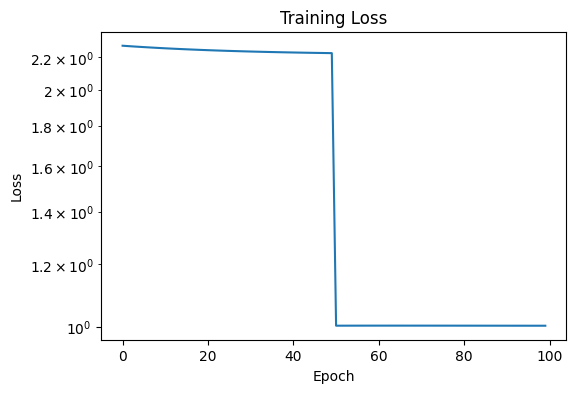

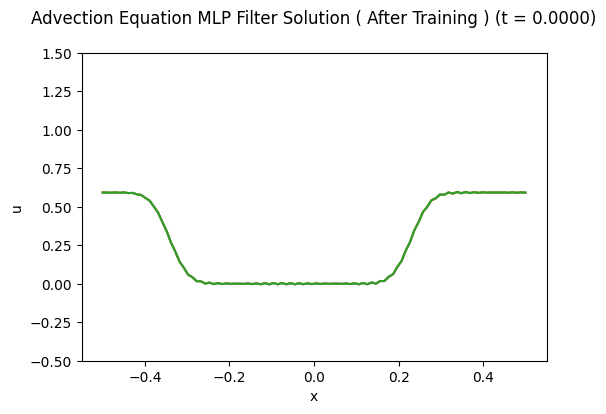

Model loaded from gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch:  50 loss: 0.53237
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch: 100 loss: 1.03731
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth


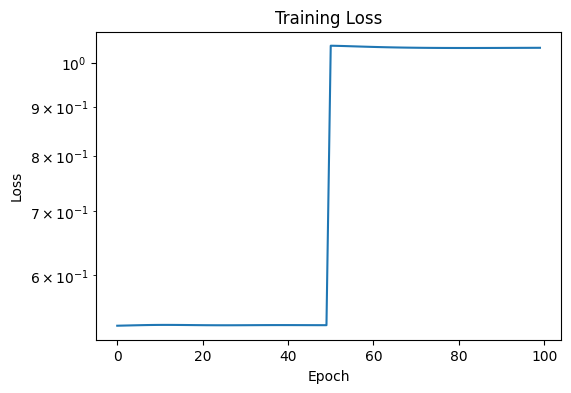

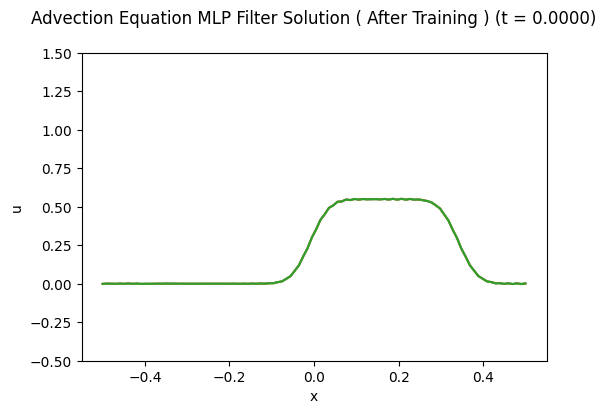

Model loaded from gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch:  50 loss: 2.61231
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth
epoch: 100 loss: 0.99698
Model saved to gibbsphen_mlp_filter_32_16_8_normalizer.pth


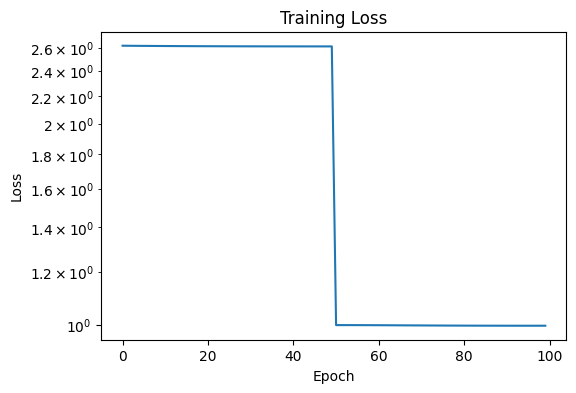

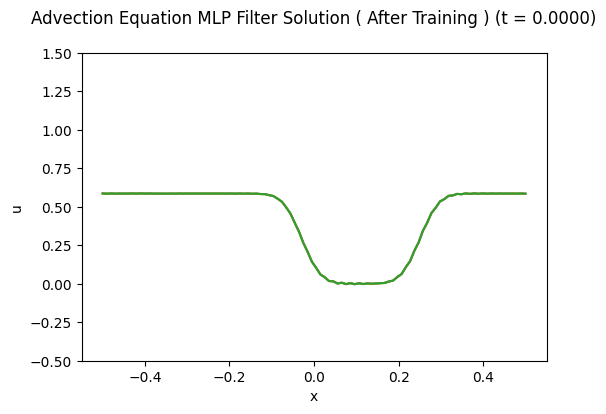

In [33]:

class MLPFilter(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate):

        super(MLPFilter, self).__init__()

        # Create layers dynamically
        self.normalizer = InputNormalizer(input_dim=5)  # Updated for 5 features

        layers = [self.normalizer]
        prev_size = input_size

        for layer_size in hidden_layers:
            layers.extend([
                nn.Linear(prev_size, layer_size),
                nn.BatchNorm1d(layer_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = layer_size

        # Final layer to output weight
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())  # Constrain weight between 0 and 1

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ------------------------------------------------------------------------------------------------

# ======================
# 1. Input Normalization (Updated for 5 features)
# ======================
class InputNormalizer(nn.Module):
    def __init__(self, input_dim=5):
        super().__init__()
        # Replace these with YOUR data's mean/std (calculated from training set)
        self.mean = nn.Parameter(torch.zeros(input_dim), requires_grad=False)
        self.std = nn.Parameter(torch.ones(input_dim), requires_grad=False)

    def forward(self, x):
        return (x - self.mean) / self.std  # Normalize to ~N(0,1)

# ==============================
# 2. CNN with Residual Blocks (Updated for 5 inputs)
# ==============================
class SpectralPool1d(nn.Module):
    """Truncates high-frequency FFT components."""
    def forward(self, x):
        x_fft = torch.fft.rfft(x, dim=-1)
        return torch.fft.irfft(x_fft[..., :x.shape[-1]//2], dim=-1)

class ResBlock(nn.Module):
    """Residual block for 1D CNNs."""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding='same')
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding='same')
        self.gelu = nn.GELU()

    def forward(self, x):
        residual = x
        x = self.gelu(self.conv1(x))
        x = self.conv2(x)
        return x + residual  # Skip connection

class CNNWithResidual(nn.Module):
    def __init__(self, input_dim=5, output_dim=1):
        super().__init__()
        # Expand 5 features to 64-dim embedding
        self.embed = nn.Linear(input_dim, 64)
        
        # CNN backbone with residuals
        self.conv_net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding='same'),  # [B, 1, 64] -> [B, 16, 64]
            ResBlock(16),
            SpectralPool1d(),                                  # [B, 16, 64] -> [B, 16, 32]
            ResBlock(16),
            nn.AdaptiveAvgPool1d(1),                          # [B, 16, 32] -> [B, 16, 1]
        )
        
        # Output head
        self.fc = nn.Sequential(
            nn.Linear(16, output_dim),
            nn.Sigmoid()  # Ensures output ∈ [0, 1]
        )

    def forward(self, x):
        x = self.embed(x).unsqueeze(1)  # Add channel dim: [B, 5] -> [B, 1, 64]
        x = self.conv_net(x).squeeze(-1)  # [B, 16]
        return self.fc(x)

# ======================
# 3. Combined Model
# ======================
class FilteringModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.normalizer = InputNormalizer(input_dim=5)  # Updated for 5 features
        self.cnn = CNNWithResidual(input_dim=5)         # Updated for 5 features

    def forward(self, x):
        x = self.normalizer(x)
        return self.cnn(x)

# # ======================
# # Usage Example
# # ======================
# if __name__ == "__main__":
#     model = FilteringModel()
#     dummy_input = torch.randn(32, 5)  # Batch of 32 samples, 5 features
#     output = model(dummy_input)
#     print(f"Output shape: {output.shape}, Range: [{output.min():.3f}, {output.max():.3f}]")    
    
# ------------------------------------------------------------------------------------------------
def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

def prepare_input_features(u, device):
    up1, up2 = np.roll(u, -1), np.roll(u, -2)
    um1, um2 = np.roll(u, 1), np.roll(u, 2)
    features = np.column_stack([um2, um1, u, up1, up2])
    return torch.tensor(features, dtype=torch.float32, device=device)

def train_mlp_filter(model, learning_rate, epochs, model_path, device, report_period):

    torch.manual_seed(0)
    # optimizer = torch.optim.LBFGS(model.parameters(), lr=1, max_iter=20)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-1)
    mse_loss = nn.MSELoss()
    # huber_loss = nn.HuberLoss()  # Default delta=1.0

    u_list = []
    loss_list = []

    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Model loaded from {model_path}")
    else:
        print("Model file does not exist. Training a new model.")

    model.train()
    for _epoch in range(epochs):

        optimizer.zero_grad()
        loss = 0

        if _epoch % report_period == 0:
            width, height, center = np.random.uniform(0.1, 0.9), np.random.uniform(0.1, 1.0), np.random.uniform(-0.5, 0.5)
            u_initial = d_alembert_solution(x, 0, width, height, center)
        
        u = u_initial.copy()
        u_list.append(u.copy())
        
        for ti in range(1, N_t):

            u_exact = d_alembert_solution(x, ti*dt, width, height, center)
            u_exact_tensor = torch.tensor(u_exact, dtype=torch.float32, device=device)

            # u_rk = RK4(u)
            u_rk = TVD_RK3(u)
            u_rk_tensor = torch.tensor(u_rk, dtype=torch.float32, device=device)

            features = prepare_input_features(u_rk, device)

            # Compute flux filtering
            up1, up2, up3, up4 = np.roll(u_rk, -1), np.roll(u_rk, -2), np.roll(u_rk, -3), np.roll(u_rk, -4)
            f2 = (up1 - u_rk) / 4
            f8 = (35*(up1-u_rk)-21*(up2-np.roll(u_rk,1))+7*(up3-np.roll(u_rk,2))-(up4-np.roll(u_rk,3)))/(4**4)
            f2_tensor = torch.tensor(f2, dtype=torch.float32, device=device)
            f8_tensor = torch.tensor(f8, dtype=torch.float32, device=device)

            w = model(features)
            w = w.squeeze(-1)
            f = (w*f2_tensor - (1-w)*f8_tensor)
            fm1 = torch.roll(f, shifts=1, dims=0)
            filtered_u = u_rk_tensor + dt/dx*(f - fm1)

            loss += mse_loss(filtered_u, u_exact_tensor)
            # loss += huber_loss(filtered_u, u_exact_tensor)
            u = filtered_u.cpu().detach().numpy()
            u_list.append(u.copy())

        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        print(f"\repoch: {_epoch+1:3} loss: {loss.item():.5f}", end="")
        if (_epoch+1) % report_period == 0:
            torch.save(model.state_dict(), model_path)
            print(f"\nModel saved to {model_path}")

    return np.array(u_list), np.array(loss_list)

### main ###
# model_path = "gibbsphen_cnn_filter_000000.pth"
model_path = "gibbsphen_mlp_filter_32_16_8_normalizer.pth"
hidden_layers = [32,16,8]
learning_rate = 1e-3
report_period = 50
epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# model = FilteringModel()
model = MLPFilter(input_size=5, hidden_layers=hidden_layers, dropout_rate=0.25)
model.to(device)
model.apply(init_weights)

for _ in range(10):
    u_mlp_filter_list, loss_list = train_mlp_filter(model, learning_rate, epochs, model_path, device, report_period)
    plot_training_loss(loss_list)

    u_mlp_filter_list_trained = u_mlp_filter_list[-N_t-1:]
    plot(u_mlp_filter_list_trained, "Advection Equation MLP Filter Solution ( After Training )")


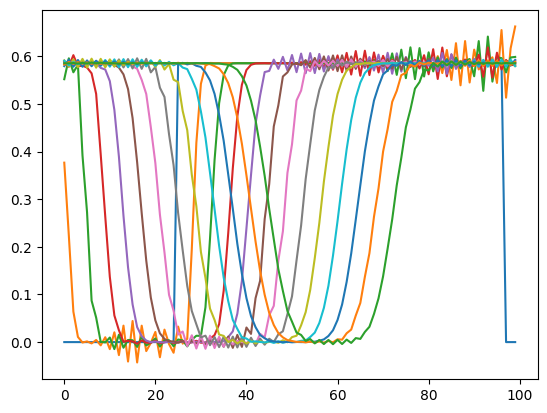

In [34]:
for i in range(0,N_t,20):
    plt.plot(u_mlp_filter_list[-N_t+i])
plt.show()

Model loaded from gibbsphen_mlp_filter_32_16_8_normalizer.pth


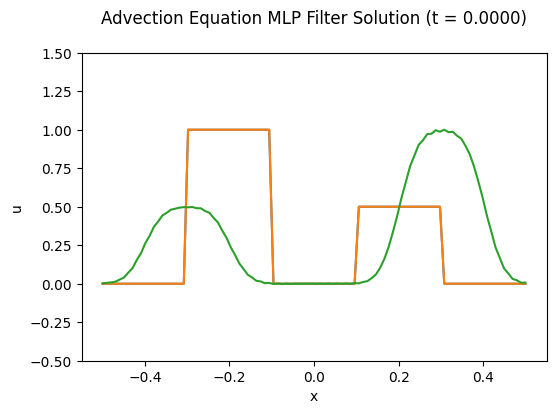

In [35]:

def solve_advection_equation_with_mlp_filter(u_initial, model, model_path, device):

    model.eval()
    with torch.no_grad():
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path, map_location=device))
            print(f"Model loaded from {model_path}")
        else:
            print("Model file does not exist.")
            return None

        u = u_initial.copy()
        u_list = [u.copy()]

        for t in range(N_t):

            # u_rk = RK4(u)
            u_rk = TVD_RK3(u)
            features = prepare_input_features(u_rk, device)
            u_rk_tensor = torch.tensor(u_rk, dtype=torch.float32, device=device)

            # Compute flux filtering
            up1, up2, up3, up4 = np.roll(u_rk, -1), np.roll(u_rk, -2), np.roll(u_rk, -3), np.roll(u_rk, -4)
            f2 = (up1 - u_rk) / 4
            f8 = (35*(up1-u_rk)-21*(up2-np.roll(u_rk,1))+7*(up3-np.roll(u_rk,2))-(up4-np.roll(u_rk,3)))/(4**4)
            f2_tensor = torch.tensor(f2, dtype=torch.float32, device=device)
            f8_tensor = torch.tensor(f8, dtype=torch.float32, device=device)

            w = model(features)
            w = w.squeeze(-1)
            f = (w*f2_tensor - (1-w)*f8_tensor)
            fm1 = torch.roll(f, shifts=1, dims=0)
            filtered_u = u_rk_tensor + dt/dx*(f - fm1)

            u = filtered_u.cpu().detach().numpy()
            u_list.append(u.copy())

        return np.array(u_list)

def u_initial_test(x):
    return u_square_wave(x,0.2,1,-0.2) + u_square_wave(x,0.2,0.5,0.2)
    # return u_square_wave(x,0.5,1,0.0)

u_initial_test_ = u_initial_test(x)
u_mlp_filter_list = solve_advection_equation_with_mlp_filter(u_initial_test_, model, model_path, device)
plot(u_mlp_filter_list, "Advection Equation MLP Filter Solution")


In [ ]:
# 14:16
# model = MyModel()
# optimizer = torch.optim.Adam(model.parameters())
# criterion = nn.CrossEntropyLoss()

# for epoch in range(num_epochs):
#     # --- Training Phase ---
#     model.train()  # Enable dropout/BatchNorm training behavior
#     for batch in train_loader:
#         optimizer.zero_grad()
#         inputs, targets = batch
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()

#     # --- Validation Phase ---
#     model.eval()  # Disable dropout, freeze BatchNorm stats
#     with torch.no_grad():  # Optional but recommended (disables gradient computation)
#         for batch in val_loader:
#             inputs, targets = batch
#             outputs = model(inputs)
#             val_loss = criterion(outputs, targets)

1.8